In [1]:
import os 
import sys
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error

In [2]:
import matplotlib as mpl
# Update matplotlib defaults to something nicer
mpl_update = {
    'font.size': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.figsize': [12.0, 8.0],
    'axes.labelsize': 20,
    'axes.labelcolor': '#677385',
    'axes.titlesize': 20,
    'lines.color': '#0055A7',
    'lines.linewidth': 3,
    'text.color': '#677385',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Tahoma'
}
mpl.rcParams.update(mpl_update)

In [3]:
# Create helper functions for specifying paths and appending
# directories with relevant python source code - for use within 
# Jupyter Notebooks in notebooks/ directory only.

# This is a lot at the top of your notebook but if you get the jupyter
# extension for collapsing headings, you can always have this and the
# imports collapsed

root_dir = os.curdir
max_nest = 5  # arbitrary, 3 would probably suffice
nest = 0
while "src" not in os.listdir(root_dir) and nest < max_nest:
    # Look up the directory structure for a src directory
    root_dir = os.path.join(os.pardir, root_dir)
    nest += 1

# If you don't find the src directory, the root directory is this directory
root_dir = os.path.abspath(root_dir) if nest < max_nest else os.path.abspath(
    os.curdir)

# Get the source directory and append path to access
# python packages/scripts within directory
if "src" in os.listdir(root_dir):
    src_dir = os.path.join(root_dir, "src")
    sys.path.append(src_dir)

# If data or figures directory don't exist in project directory,
# they will be saved to this directory
data_dir = os.path.join(
    root_dir, "data") if "data" in os.listdir(root_dir) else os.curdir
figure_dir = os.path.join(
    root_dir,
    "figures") if "figures" in os.listdir(root_dir) else os.curdir
models_dir = os.path.join(
    root_dir,
    "models") if "models" in os.listdir(root_dir) else os.curdir

# Prepends the directory path for specifying paths to data or figures
# dataplus("data.csv") -> "/Users/cmawer/project/data/data.csv"
# figplus("cool.png") -> "/Users/cmawer/project/figures/cool.png"
dataplus = lambda x: os.path.join(data_dir, x)
figplus = lambda x: os.path.join(figure_dir, x)
modelsplus = lambda x: os.path.join(models_dir, x)

# Prepends the date to a string (e.g. to save dated files)
# dateplus("cool-figure.png") -> "2018-12-05-cool-figure.png"
now = datetime.datetime.now().strftime("%Y-%m-%d")
dateplus = lambda x: "%s-%s" % (now, x)

## The DataSet

We will be using the [100,000 UK Used Car Data set](https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?datasetId=750216&searchQuery=bmw&select=bmw.csv)

In [10]:
bmw = pd.read_csv('/Users/franklin/Desktop/2022-msia423-yihanzhou/data/bmw2.csv')
bmw.shape

(10781, 9)

In [12]:
bmw.drop(['Unnamed: 0'], axis=1, inplace=True)

In [13]:
bmw.head()

,model,year,price,transmission,mileage,fuelType,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,50.4,3.0


In [14]:
bmw.describe()

,year,price,mileage,mpg,engineSize
count,10781.000000,10781.000000,10781.000000,10781.000000,10781.000000
mean,2017.078935,22733.408867,25496.986550,56.399035,2.167767
std,2.349038,11415.528189,25143.192559,31.336958,0.552054
min,1996.000000,1200.000000,1.000000,5.500000,0.000000
25%,2016.000000,14950.000000,5529.000000,45.600000,2.000000
50%,2017.000000,20462.000000,18347.000000,53.300000,2.000000
75%,2019.000000,27940.000000,38206.000000,62.800000,2.000000
max,2020.000000,123456.000000,214000.000000,470.800000,6.600000


In [8]:
bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   mpg           10781 non-null  float64
 7   engineSize    10781 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 673.9+ KB


In [15]:
bmw.model = bmw.model.str.strip()

In [16]:
bmw.apply(lambda x: x.nunique(), axis = 0)

model             24
year              25
price           3777
transmission       3
mileage         8086
fuelType           5
mpg              102
engineSize        17
dtype: int64

In [17]:
bmw.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'mpg',
       'engineSize'],
      dtype='object')

In [18]:
bmw.year.unique()
##year from 1996-2019

array([2014, 2018, 2016, 2017, 2015, 2019, 2013, 2020, 2002, 2004, 2007,
       2008, 2011, 2012, 2009, 2006, 2010, 2003, 2001, 2005, 2000, 1999,
       1996, 1997, 1998])

In [19]:
bmw.model.unique()

array(['5 Series', '6 Series', '1 Series', '7 Series', '2 Series',
       '4 Series', 'X3', '3 Series', 'X5', 'X4', 'i3', 'X1', 'M4', 'X2',
       'X6', '8 Series', 'Z4', 'X7', 'M5', 'i8', 'M2', 'M3', 'M6', 'Z3'],
      dtype=object)

In [20]:
bmw.transmission.unique()

array(['Automatic', 'Manual', 'Semi-Auto'], dtype=object)

In [24]:
group1

,model,year,price,mileage,fuelType,mpg,engineSize
transmission,,,,,,,
Automatic,3588,3588,3588,3588,3588,3588,3588
Manual,2527,2527,2527,2527,2527,2527,2527
Semi-Auto,4666,4666,4666,4666,4666,4666,4666


In [23]:
group1 = bmw.groupby('transmission').count()

Text(0.5, 1.0, 'Pie Plot of Transmission Type')

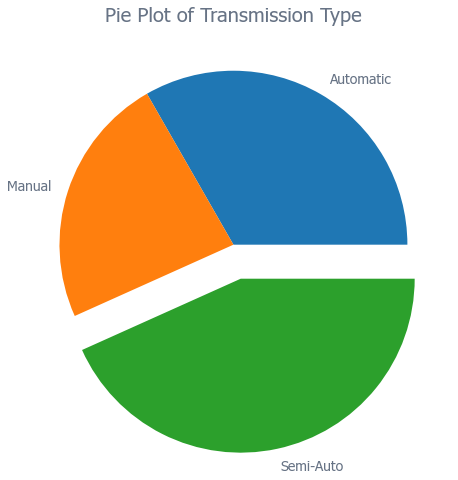

In [36]:
plt.pie(group1.model,labels = group1.index,explode = [0,0,0.2])
plt.title("Pie Plot of Transmission Type")

In [15]:
bmw.fuelType.unique()

array(['Diesel', 'Petrol', 'Other', 'Hybrid', 'Electric'], dtype=object)

Text(0.5, 1.0, 'Pie Plot of Fuel Type')

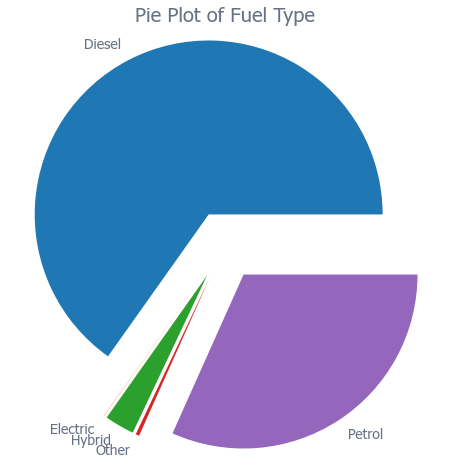

In [43]:
group2 = bmw.groupby('fuelType').count()
plt.pie(group2.model,labels = group2.index, explode = [0.2,0.2,0.2,0.2,0.2])
plt.title("Pie Plot of Fuel Type")

In [11]:
bmw.engineSize.unique()

array([2. , 3. , 1.5, 0.6, 1.6, 4.4, 0. , 2.2, 2.5, 4. , 3.2, 1. , 5. ,
       1.9, 6.6, 2.8, 3.5])

In [16]:
bmw.model.value_counts()

3 Series    2443
1 Series    1969
2 Series    1229
5 Series    1056
4 Series     995
X1           804
X3           551
X5           468
X2           288
X4           179
M4           125
6 Series     108
Z4           108
X6           106
7 Series     106
X7            55
i3            43
8 Series      39
M5            29
M3            27
M2            21
i8            17
M6             8
Z3             7
Name: model, dtype: int64

In [17]:
bmw['transmission'].value_counts()

Semi-Auto    4666
Automatic    3588
Manual       2527
Name: transmission, dtype: int64

In [39]:
bmw['fuelType'].value_counts()

Diesel      7027
Petrol      3417
Hybrid       298
Other         36
Electric       3
Name: fuelType, dtype: int64

In [96]:
## 1. check the na values
bmw.isnull().sum()
## there is no missing value

Unnamed: 0      0
Unnamed: 0.1    0
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
dtype: int64

In [40]:
def get_categorical_columns(df):
    """get the categorical columns from the dataframe
    
    Args:
         df: :obj: `pandas.DataFrame` with the columns, `model`,`year`,`price`,`transmission`,`millage`,`fuelType`,`tax`,`mpg`,`engineSize`
        
    Returns:
        str(num_col): :str: a list of categorical column names
    """
    cat_col = [col for col in df.columns if df[col].dtype == 'object']
    return str(cat_col)

In [41]:
get_categorical_columns(bmw)

"['model', 'transmission', 'fuelType']"

In [16]:
cat_col = [col for col in bmw.columns if bmw[col].dtype == 'object']
cat_col

['model', 'transmission', 'fuelType']

In [43]:
# Get numerical columns
num_col = [col for col in train.columns if train[col].dtype != 'object']
print('Numerical Columns\n'+ str(num_col))

# Get categorical columns
cat_col = [col for col in train.columns if train[col].dtype == 'object']
print('\nCategorical Columns\n'+ str(cat_col))

NameError: name 'train' is not defined

In [18]:
bmw.drop("tax", axis=1, inplace=True)

KeyError: "['tax'] not found in axis"

In [19]:
bmw.to_csv('bmw.csv')

In [20]:
bmw.head()

,model,year,price,transmission,mileage,fuelType,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,50.4,3.0


In [45]:
x = bmw.drop('price', axis = 1)
y = bmw['price']

In [12]:
categorical_cols = ['model','transmission','fuelType']

In [47]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [73]:
ohe_data = pd.DataFrame(ohe.fit_transform(bmw[categorical_cols]).toarray(),
                        columns = ohe.get_feature_names())

In [74]:
ohe_data

,x0_1 Series,x0_2 Series,x0_3 Series,x0_4 Series,x0_5 Series,x0_6 Series,x0_7 Series,x0_8 Series,x0_M2,x0_M3,...,x0_i3,x0_i8,x1_Automatic,x1_Manual,x1_Semi-Auto,x2_Diesel,x2_Electric,x2_Hybrid,x2_Other,x2_Petrol
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10777,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10778,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
10779,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [50]:
x = pd.concat([ohe_data, x], axis = 1).drop(categorical_cols,axis = 1)
x.head()

,x0_1 Series,x0_2 Series,x0_3 Series,x0_4 Series,x0_5 Series,x0_6 Series,x0_7 Series,x0_8 Series,x0_M2,x0_M3,...,x1_Semi-Auto,x2_Diesel,x2_Electric,x2_Hybrid,x2_Other,x2_Petrol,year,mileage,mpg,engineSize
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2014,67068,57.6,2.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2018,14827,42.8,2.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2016,62794,51.4,3.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2017,26676,72.4,1.5
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2014,39554,50.4,3.0


In [51]:
x.columns

Index(['x0_1 Series', 'x0_2 Series', 'x0_3 Series', 'x0_4 Series',
       'x0_5 Series', 'x0_6 Series', 'x0_7 Series', 'x0_8 Series', 'x0_M2',
       'x0_M3', 'x0_M4', 'x0_M5', 'x0_M6', 'x0_X1', 'x0_X2', 'x0_X3', 'x0_X4',
       'x0_X5', 'x0_X6', 'x0_X7', 'x0_Z3', 'x0_Z4', 'x0_i3', 'x0_i8',
       'x1_Automatic', 'x1_Manual', 'x1_Semi-Auto', 'x2_Diesel', 'x2_Electric',
       'x2_Hybrid', 'x2_Other', 'x2_Petrol', 'year', 'mileage', 'mpg',
       'engineSize'],
      dtype='object')

In [52]:
x.shape

(10781, 36)

In [53]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [54]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [55]:
print("x_train shape is:",x_train.shape)
print("x_test shape is:",x_test.shape)

x_train shape is: (8624, 36)
x_test shape is: (2157, 36)


In [56]:
type(y_train)

pandas.core.series.Series

In [57]:
RandomForestRegressorModel = RandomForestRegressor(random_state=22,max_depth = 40)
RandomForestRegressorModel.fit(x_train, y_train)
print('Random Forest Regressor Train Score is : ' , RandomForestRegressorModel.score(x_train, y_train))
print('Random Forest Regressor Test Score is : ' , RandomForestRegressorModel.score(x_test, y_test))

Random Forest Regressor Train Score is :  0.9923162014703784
Random Forest Regressor Test Score is :  0.9525604018397017


In [60]:
y_pred = RandomForestRegressorModel.predict(x_test)

In [61]:
y_pred

array([15769.37, 20891.45, 28819.9 , ..., 20856.61, 24251.28, 13073.74])

In [62]:
type(y_pred)

numpy.ndarray

In [63]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9525604018397017

In [48]:
from sklearn import metrics

In [61]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 1535.891418636996
Mean Squared Error (MSE): 12150170.440088967
Root Mean Squared Error (RMSE): 3485.709460079679
Mean Absolute Percentage Error (MAPE): 6.88
Accuracy: 93.12


In [78]:
r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
result = pd.DataFrame({"R2": r2, "MAE": mae, "MSE": mse},index=[])

In [79]:
result

,R2,MAE,MSE
1,0.903634,1535.891419,1.215017e+07
2,0.903634,1535.891419,1.215017e+07
3,0.903634,1535.891419,1.215017e+07


In [5]:
user_input = {'model': '5 Series',
              'year': 2017,
              'transmission': 'Semi-Auto',
              'mileage': 67068,
              'fuelType': 'Diesel',
              'mpg': 60,
              'engineSize': 20}

In [6]:
user_input

{'model': '5 Series',
 'year': 2017,
 'transmission': 'Semi-Auto',
 'mileage': 67068,
 'fuelType': 'Diesel',
 'mpg': 60,
 'engineSize': 20}

In [7]:
data = pd.DataFrame(user_input,index=[0])
data

,model,year,transmission,mileage,fuelType,mpg,engineSize
0,5 Series,2017,Semi-Auto,67068,Diesel,60,20


In [13]:
ohe_cols = ['x0_1 Series', 'x0_2 Series', 'x0_3 Series', 'x0_4 Series',
       'x0_5 Series', 'x0_6 Series', 'x0_7 Series', 'x0_8 Series', 'x0_M2',
       'x0_M3', 'x0_M4', 'x0_M5', 'x0_M6', 'x0_X1', 'x0_X2', 'x0_X3', 'x0_X4',
       'x0_X5', 'x0_X6', 'x0_X7', 'x0_Z3', 'x0_Z4', 'x0_i3', 'x0_i8',
       'x1_Automatic', 'x1_Manual', 'x1_Semi-Auto', 'x2_Diesel', 'x2_Electric',
       'x2_Hybrid', 'x2_Other', 'x2_Petrol', 'year', 'mileage', 'mpg',
       'engineSize']

In [14]:
ohe_empty = pd.DataFrame(columns=ohe_cols)
ohe_empty

,x0_1 Series,x0_2 Series,x0_3 Series,x0_4 Series,x0_5 Series,x0_6 Series,x0_7 Series,x0_8 Series,x0_M2,x0_M3,...,x1_Semi-Auto,x2_Diesel,x2_Electric,x2_Hybrid,x2_Other,x2_Petrol,year,mileage,mpg,engineSize


In [15]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [17]:
data1 = pd.DataFrame(ohe.fit_transform(data[cat_col]).toarray(),
                        columns = ohe.get_feature_names())

In [18]:
data1

,x0_5 Series,x1_Semi-Auto,x2_Diesel
0,1.0,1.0,1.0


In [19]:
x = pd.concat([data1, data], axis = 1).drop(cat_col,axis = 1)
x.head()

,x0_5 Series,x1_Semi-Auto,x2_Diesel,year,mileage,mpg,engineSize
0,1.0,1.0,1.0,2017,67068,60,20


In [20]:
for col in ohe_empty.columns:
    if col in x.columns:
        ohe_empty[col] = x[col]
    else:
        ohe_empty[col] = 0
        

In [21]:
test = ohe_empty.copy()
test

,x0_1 Series,x0_2 Series,x0_3 Series,x0_4 Series,x0_5 Series,x0_6 Series,x0_7 Series,x0_8 Series,x0_M2,x0_M3,...,x1_Semi-Auto,x2_Diesel,x2_Electric,x2_Hybrid,x2_Other,x2_Petrol,year,mileage,mpg,engineSize
0,NaN,NaN,NaN,NaN,1.0,0,0,0,0,0,...,1.0,1.0,0,0,0,0,2017,67068,60,20


In [22]:
test = test.fillna(0)

In [23]:
test.values

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0170e+03, 6.7068e+04, 6.0000e+01,
        2.0000e+01]])

In [115]:
RandomForestRegressorModel.predict(ohe_empty)

array([43311.52333333])